In [1]:
# 隨機從dataset中挑選N筆資料
from os import walk
from os.path import join
from os import stat
import random
import hashlib
import time

mypath = "D:\Download\chunkhash\enron"

# store all the fullpath of files in the root directory
file_names = []


for root, dirs, files in walk(mypath):
    for f in files:
        fullpath = join(root, f)
        file_names.append(fullpath)

In [2]:
# store 1000 fullpath to upload
upload_files = []
# store 200 fullpath to check dulplicate
check_files = []

# three lists simulate cloud server
dirty_chunk = []
cloud_chunk = []
cloud_hash = []

# check file data
check_chunk = []
check_hash = []

In [3]:
# os.stat(file).st_size return size of the file in bytes
for i in range(1000):
    random_int = random.randint(0, len(file_names) - 1)
    upload_files.append(file_names[random_int])
    
for i in range(200):
    random_int = random.randint(0, len(file_names) - 1)
    check_files.append(file_names[random_int])
    
same_file = 0
for cf in check_files:
    if(cf in upload_files):
        same_file += 1
print('same file amount between cloud file and check file:', same_file)

same file amount between cloud file and check file: 0


In [4]:
def upload_file(upload_file_list, chunk_size):
    for file in upload_file_list:
        with open(file, 'rb') as f:
            text = f.read()
        f.close()

#         if(len(text) % chunk_size != 0):
#             for i in range(chunk_size - (len(text) % chunk_size)):
#                 text += bytes.fromhex('30')
        
        text_chunk = []
        for i in range(0, len(text), chunk_size):
            text_chunk.append(text[i: i + chunk_size])
        cloud_chunk.extend(text_chunk)
        
        text_hash = []
        for i in range(len(text_chunk)):
            hash_text = hashlib.sha256(text_chunk[i]).hexdigest()
            text_hash.append(hash_text)
        cloud_hash.extend(text_hash)
        
def cut_check_file(check_file_list, chunk_size):
    for file in check_file_list:
        with open(file, 'rb') as f:
            text = f.read()
        f.close()
        
#         if(len(text) % chunk_size != 0):
#             for j in range(chunk_size - (len(text) % chunk_size)):
#                 text += bytes.fromhex('30')
        
        text_chunk = []
        for i in range(0, len(text), chunk_size):
            text_chunk.append(text[i: i + chunk_size])
            
        if(len(text_chunk) % 2 != 0):
            rand_chunk = text_chunk[random.randint(0, len(text_chunk) - 1)]
            text_chunk.append(rand_chunk)
        check_chunk.extend(text_chunk)
        
        text_hash = []
        for i in range(len(text_chunk)):
            hash_text = hashlib.sha256(text_chunk[i]).hexdigest()
            text_hash.append(hash_text)
        check_hash.extend(text_hash)

In [5]:
def set_dirty_chunk(dirty_percent):
    for i in range(int(len(cloud_hash) * dirty_percent)):
        dirty_chunk.append(cloud_hash[random.randint(0, len(cloud_hash) - 1)])

def zeus_check(chunk1, chunk2, hash_list):
    num = 0
    existence = 0
    for i in range(len(hash_list)):
        if(chunk1 == hash_list[i][0]):
            existence += 1
            if(hash_list[i][1] > 0):
                hash_list[i][1] -=1
            else:
                num += 1
            break
    if(existence < 1):
        hash_list.append([chunk1, 0])
    for i in range(len(hash_list)):
        if(chunk2 == hash_list[i][0]):
            existence += 1
            if(hash_list[i][1] > 0):
                hash_list[i][1] -=1
            else:
                num += 1
            break
    if(existence < 2):
        hash_list.append([chunk2, 0])
        
    return num

def zeus(chunk1, chunk2, hash_list):
    num = 0
    if(chunk1 in hash_list):
        num += 1
    else:
        hash_list.append(chunk1)
    if(chunk2 in hash_list):
        num += 1
    else:
        hash_list.append(chunk2)
    
    return num

def cal_commu_cost(chunk_size, is_zeus, has_dirty, thresh_max):
    upload_time = 0
    cost = 0
    cloud_copy = cloud_chunk.copy()
    hash_copy = cloud_hash.copy()
    dirty_copy = dirty_chunk.copy()
    
#     start_time = time.time()
    
    if(thresh_max > 0):
        for i in range(len(hash_copy)):
            hash_copy[i] = [hash_copy[i], random.randint(1, thresh_max)]
   
    if(is_zeus and thresh_max > 0):
        for i in range(0, len(check_hash), 2):
            cost += 64
            if(has_dirty):
                if((check_hash[i] in dirty_copy) or (check_hash[i + 1] in dirty_copy)):
                    cloud_copy.append(check_chunk[i])
                    cloud_copy.append(check_chunk[i + 1])
                    if(check_hash[i] in dirty_copy):
                        dirty_copy.remove(check_hash[i])
                    if(check_hash[i + 1] in dirty_copy):
                        dirty_copy.remove(check_hash[i + 1])
                    val = zeus_check(check_hash[i], check_hash[i + 1], hash_copy)
                    cost += chunk_size * 2
                    upload_time += 2
                    continue
                    
            val = zeus_check(check_hash[i], check_hash[i + 1], hash_copy)
            if(val == 0):
                cloud_copy.append(check_chunk[i])
                cloud_copy.append(check_chunk[i + 1])
                cost += chunk_size * 2
                upload_time += 2
            else:
                xor_result = hex(int(check_chunk[i].hex(), 16) ^ int(check_chunk[i + 1].hex(), 16))[2:]
                if(len(xor_result) < (chunk_size * 2)):
                    for i in range((chunk_size * 2) - len(xor_result)):
                        xor_result = '0' + xor_result
                cloud_copy.append(bytes.fromhex(xor_result))
                cost += chunk_size
                upload_time += 1
                    
    if(is_zeus and thresh_max == 0):
        for i in range(0, len(check_hash), 2):
            cost += 64
            if(has_dirty):
                if((check_hash[i] in dirty_copy) or (check_hash[i + 1] in dirty_copy)):
                    cloud_copy.append(check_chunk[i])
                    cloud_copy.append(check_chunk[i + 1])
                    if(check_hash[i] in dirty_copy):
                        dirty_copy.remove(check_hash[i])
                    if(check_hash[i] not in hash_copy):
                        hash_copy.append(check_hash[i])
                    if(check_hash[i + 1] in dirty_copy):
                        dirty_copy.remove(check_hash[i + 1])
                    if(check_hash[i + 1] not in hash_copy):
                        hash_copy.append(check_hash[i + 1])
                    cost += chunk_size * 2
                    upload_time += 2
                    continue
                    
            val = zeus(check_hash[i], check_hash[i + 1], hash_copy)        
            if(val == 0):
                cloud_copy.append(check_chunk[i])
                cloud_copy.append(check_chunk[i + 1])
                cost += chunk_size * 2
                upload_time += 2
            else:
                xor_result = hex(int(check_chunk[i].hex(), 16) ^ int(check_chunk[i + 1].hex(), 16))[2:]
                if(len(xor_result) < (chunk_size * 2)):
                    for i in range((chunk_size * 2) - len(xor_result)):
                        xor_result = '0' + xor_result
                cloud_copy.append(bytes.fromhex(xor_result))
                cost += chunk_size
                upload_time += 1
    if(not is_zeus):
        for i in range(len(check_hash)):
            cost += 32
            if(has_dirty):
                if(check_hash[i] in dirty_copy):
                    cloud_copy.append(check_chunk[i])
                    dirty_copy.remove(check_hash[i])
                    if(check_hash[i] not in hash_copy):
                        hash_copy.append(check_hash[i])
                    cost += chunk_size
                    upload_time += 1
                    continue
            if(check_hash[i] not in hash_copy):
                cloud_copy.append(check_chunk[i])
                hash_copy.append(check_hash[i])
                cost += chunk_size
                upload_time += 1
                
#     end_time = time.time()
    if(has_dirty):
        if(is_zeus):
            if(thresh_max > 0):
                print('dirty ZEUS having threshold %d, with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (thresh_max, chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
            else:
                print('dirty ZEUS with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
        else:
            print('dirty original dedup with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    elif(is_zeus):
        if(thresh_max > 0):
            print('ZEUS having threshold %d, with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (thresh_max, chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
        else:
            print('ZEUS with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    else:
        print('origin dedup with chunk size: %d bytes,  dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    
    cost -= len(check_hash) * 32
    return cost

In [6]:
def rare(chunk1, chunk2, hash_list):
    num = 0
    if(chunk1 in hash_list):
        num += 1
    else:
        hash_list.append(chunk1)
    if(chunk2 in hash_list):
        num += 1
    else:
        hash_list.append(chunk2)
    
    if(num == 0):
        return 2
    else:
        val = random.randint(1, 2)
        return val

def rare_cost(chunk_size, do_dedup, do_rare, has_dirty):
    upload_time = 0
    cost = 0
    cloud_copy = cloud_chunk.copy()
    hash_copy = cloud_hash.copy()
    dirty_copy = dirty_chunk.copy()
    
#     start_time = time.time()
    
    if(do_dedup and do_rare):        
        for i in range(0, len(check_hash), 2):
            cost += 64
            if(has_dirty):
                if((check_hash[i] in dirty_copy) or (check_hash[i + 1] in dirty_copy)):
                    cloud_copy.append(check_chunk[i])
                    cloud_copy.append(check_chunk[i + 1])
                    if(check_hash[i] in dirty_copy):
                        dirty_copy.remove(check_hash[i])
                    if(check_hash[i] not in hash_copy):
                        hash_copy.append(check_hash[i])
                    if(check_hash[i + 1] in dirty_copy):
                        dirty_copy.remove(check_hash[i + 1])
                    if(check_hash[i + 1] not in hash_copy):
                        hash_copy.append(check_hash[i + 1])
                    cost += chunk_size * 2
                    upload_time += 2
                    continue
            
            val = rare(check_hash[i], check_hash[i + 1], hash_copy)
            if(val == 2):
                cloud_copy.append(check_chunk[i])
                cloud_copy.append(check_chunk[i + 1])
                cost += chunk_size * 2
                upload_time += 2
            else:
                xor_result = hex(int(check_chunk[i].hex(), 16) ^ int(check_chunk[i + 1].hex(), 16))[2:]
                if(len(xor_result) < (chunk_size * 2)):
                    for i in range((chunk_size * 2) - len(xor_result)):
                        xor_result = '0' + xor_result
                cloud_copy.append(bytes.fromhex(xor_result))
                cost += chunk_size
                upload_time += 1
    if(do_dedup and (not do_rare)):
        for i in range(len(check_hash)):
            cost += 32
            if(has_dirty):
                if(check_hash[i] in dirty_copy):
                    cloud_copy.append(check_chunk[i])
                    dirty_copy.remove(check_hash[i])
                    cost += chunk_size
                    upload_time += 1
                    if(check_hash[i] not in hash_copy):
                        hash_copy.append(check_hash[i])
                    continue
                
            if(check_hash[i] not in hash_copy):
                cloud_copy.append(check_chunk[i])
                hash_copy.append(check_hash[i])
                cost += chunk_size
                upload_time += 1
    if(not do_dedup):
        cost = (32 + chunk_size) * len(check_hash)
        upload_time += len(check_hash)
    
#     end_time = time.time()
    if(has_dirty):
        if(do_rare):
            print('dirty RARE with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
        else:
            print('dirty original dedup with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    elif(do_rare):
        print('RARE with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    elif(do_dedup):
        print('origin dedup with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    else:
        print('no dedup with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    
    cost -= len(check_hash) * 32
    return cost

In [7]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

origin_costs = []
zeus_costs = []
zeus5_costs = []
zeus20_costs = []
zeus40_costs = []

no_dedup_costs = []
origin_dedup_costs = []
rare_costs = []

# no dirty chunk 128B
upload_file(upload_files, 128)
cut_check_file(check_files, 128)
origin_costs.append(cal_commu_cost(128, False, False, 0))
zeus_costs.append(cal_commu_cost(128, True, False, 0))
zeus5_costs.append(cal_commu_cost(128, True, False, 5))
zeus20_costs.append(cal_commu_cost(128, True, False, 20))
zeus40_costs.append(cal_commu_cost(128, True, False, 40))

no_dedup_costs.append(rare_cost(128, False, False, False))
origin_dedup_costs.append(rare_cost(128, True, False, False))
rare_costs.append(rare_cost(128, True, True, False))

origin dedup with chunk size: 128 bytes,  dedup times: 150, check times: 4946, dedup percentage: 3.032754 %
ZEUS with chunk size: 128 bytes, dedup times: 128, check times: 4946, dedup percentage: 2.587950 %
ZEUS having threshold 5, with chunk size: 128 bytes, dedup times: 90, check times: 4946, dedup percentage: 1.819652 %
ZEUS having threshold 20, with chunk size: 128 bytes, dedup times: 90, check times: 4946, dedup percentage: 1.819652 %
ZEUS having threshold 40, with chunk size: 128 bytes, dedup times: 90, check times: 4946, dedup percentage: 1.819652 %
no dedup with chunk size: 128 bytes, dedup times: 0, check times: 4946, dedup percentage: 0.000000 %
origin dedup with chunk size: 128 bytes, dedup times: 150, check times: 4946, dedup percentage: 3.032754 %
RARE with chunk size: 128 bytes, dedup times: 68, check times: 4946, dedup percentage: 1.374848 %


In [8]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# no dirty chunk 256B
upload_file(upload_files, 256)
cut_check_file(check_files, 256)
origin_costs.append(cal_commu_cost(256, False, False, 0))
zeus_costs.append(cal_commu_cost(256, True, False, 0))
zeus5_costs.append(cal_commu_cost(256, True, False, 5))
zeus20_costs.append(cal_commu_cost(256, True, False, 20))
zeus40_costs.append(cal_commu_cost(256, True, False, 40))

no_dedup_costs.append(rare_cost(256, False, False, False))
origin_dedup_costs.append(rare_cost(256, True, False, False))
rare_costs.append(rare_cost(256, True, True, False))

origin dedup with chunk size: 256 bytes,  dedup times: 129, check times: 2582, dedup percentage: 4.996127 %
ZEUS with chunk size: 256 bytes, dedup times: 125, check times: 2582, dedup percentage: 4.841208 %
ZEUS having threshold 5, with chunk size: 256 bytes, dedup times: 107, check times: 2582, dedup percentage: 4.144074 %
ZEUS having threshold 20, with chunk size: 256 bytes, dedup times: 107, check times: 2582, dedup percentage: 4.144074 %
ZEUS having threshold 40, with chunk size: 256 bytes, dedup times: 107, check times: 2582, dedup percentage: 4.144074 %
no dedup with chunk size: 256 bytes, dedup times: 0, check times: 2582, dedup percentage: 0.000000 %
origin dedup with chunk size: 256 bytes, dedup times: 129, check times: 2582, dedup percentage: 4.996127 %
RARE with chunk size: 256 bytes, dedup times: 52, check times: 2582, dedup percentage: 2.013943 %


In [9]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# no dirty chunk 512B
upload_file(upload_files, 512)
cut_check_file(check_files, 512)
origin_costs.append(cal_commu_cost(512, False, False, 0))
zeus_costs.append(cal_commu_cost(512, True, False, 0))
zeus5_costs.append(cal_commu_cost(512, True, False, 5))
zeus20_costs.append(cal_commu_cost(512, True, False, 20))
zeus40_costs.append(cal_commu_cost(512, True, False, 40))

no_dedup_costs.append(rare_cost(512, False, False, False))
origin_dedup_costs.append(rare_cost(512, True, False, False))
rare_costs.append(rare_cost(512, True, True, False))

origin dedup with chunk size: 512 bytes,  dedup times: 89, check times: 1376, dedup percentage: 6.468023 %
ZEUS with chunk size: 512 bytes, dedup times: 89, check times: 1376, dedup percentage: 6.468023 %
ZEUS having threshold 5, with chunk size: 512 bytes, dedup times: 84, check times: 1376, dedup percentage: 6.104651 %
ZEUS having threshold 20, with chunk size: 512 bytes, dedup times: 84, check times: 1376, dedup percentage: 6.104651 %
ZEUS having threshold 40, with chunk size: 512 bytes, dedup times: 84, check times: 1376, dedup percentage: 6.104651 %
no dedup with chunk size: 512 bytes, dedup times: 0, check times: 1376, dedup percentage: 0.000000 %
origin dedup with chunk size: 512 bytes, dedup times: 89, check times: 1376, dedup percentage: 6.468023 %
RARE with chunk size: 512 bytes, dedup times: 47, check times: 1376, dedup percentage: 3.415698 %


In [10]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# no dirty chunk 1KB
upload_file(upload_files, 1024)
cut_check_file(check_files, 1024)
origin_costs.append(cal_commu_cost(1024, False, False, 0))
zeus_costs.append(cal_commu_cost(1024, True, False, 0))
zeus5_costs.append(cal_commu_cost(1024, True, False, 5))
zeus20_costs.append(cal_commu_cost(1024, True, False, 20))
zeus40_costs.append(cal_commu_cost(1024, True, False, 40))

no_dedup_costs.append(rare_cost(1024, False, False, False))
origin_dedup_costs.append(rare_cost(1024, True, False, False))
rare_costs.append(rare_cost(1024, True, True, False))

origin dedup with chunk size: 1024 bytes,  dedup times: 98, check times: 786, dedup percentage: 12.468193 %
ZEUS with chunk size: 1024 bytes, dedup times: 98, check times: 786, dedup percentage: 12.468193 %
ZEUS having threshold 5, with chunk size: 1024 bytes, dedup times: 98, check times: 786, dedup percentage: 12.468193 %
ZEUS having threshold 20, with chunk size: 1024 bytes, dedup times: 98, check times: 786, dedup percentage: 12.468193 %
ZEUS having threshold 40, with chunk size: 1024 bytes, dedup times: 98, check times: 786, dedup percentage: 12.468193 %
no dedup with chunk size: 1024 bytes, dedup times: 0, check times: 786, dedup percentage: 0.000000 %
origin dedup with chunk size: 1024 bytes, dedup times: 98, check times: 786, dedup percentage: 12.468193 %
RARE with chunk size: 1024 bytes, dedup times: 59, check times: 786, dedup percentage: 7.506361 %


In [11]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# no dirty chunk 2KB
upload_file(upload_files, 2048)
cut_check_file(check_files, 2048)
origin_costs.append(cal_commu_cost(2048, False, False, 0))
zeus_costs.append(cal_commu_cost(2048, True, False, 0))
zeus5_costs.append(cal_commu_cost(2048, True, False, 5))
zeus20_costs.append(cal_commu_cost(2048, True, False, 20))
zeus40_costs.append(cal_commu_cost(2048, True, False, 40))

no_dedup_costs.append(rare_cost(2048, False, False, False))
origin_dedup_costs.append(rare_cost(2048, True, False, False))
rare_costs.append(rare_cost(2048, True, True, False))

origin dedup with chunk size: 2048 bytes,  dedup times: 153, check times: 546, dedup percentage: 28.021978 %
ZEUS with chunk size: 2048 bytes, dedup times: 153, check times: 546, dedup percentage: 28.021978 %
ZEUS having threshold 5, with chunk size: 2048 bytes, dedup times: 153, check times: 546, dedup percentage: 28.021978 %
ZEUS having threshold 20, with chunk size: 2048 bytes, dedup times: 153, check times: 546, dedup percentage: 28.021978 %
ZEUS having threshold 40, with chunk size: 2048 bytes, dedup times: 153, check times: 546, dedup percentage: 28.021978 %
no dedup with chunk size: 2048 bytes, dedup times: 0, check times: 546, dedup percentage: 0.000000 %
origin dedup with chunk size: 2048 bytes, dedup times: 153, check times: 546, dedup percentage: 28.021978 %
RARE with chunk size: 2048 bytes, dedup times: 85, check times: 546, dedup percentage: 15.567766 %


In [12]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# no dirty chunk 4KB
upload_file(upload_files, 4096)
cut_check_file(check_files, 4096)
origin_costs.append(cal_commu_cost(4096, False, False, 0))
zeus_costs.append(cal_commu_cost(4096, True, False, 0))
zeus5_costs.append(cal_commu_cost(4096, True, False, 5))
zeus20_costs.append(cal_commu_cost(4096, True, False, 20))
zeus40_costs.append(cal_commu_cost(4096, True, False, 40))

no_dedup_costs.append(rare_cost(4096, False, False, False))
origin_dedup_costs.append(rare_cost(4096, True, False, False))
rare_costs.append(rare_cost(4096, True, True, False))

origin dedup with chunk size: 4096 bytes,  dedup times: 179, check times: 452, dedup percentage: 39.601770 %
ZEUS with chunk size: 4096 bytes, dedup times: 179, check times: 452, dedup percentage: 39.601770 %
ZEUS having threshold 5, with chunk size: 4096 bytes, dedup times: 179, check times: 452, dedup percentage: 39.601770 %
ZEUS having threshold 20, with chunk size: 4096 bytes, dedup times: 179, check times: 452, dedup percentage: 39.601770 %
ZEUS having threshold 40, with chunk size: 4096 bytes, dedup times: 179, check times: 452, dedup percentage: 39.601770 %
no dedup with chunk size: 4096 bytes, dedup times: 0, check times: 452, dedup percentage: 0.000000 %
origin dedup with chunk size: 4096 bytes, dedup times: 179, check times: 452, dedup percentage: 39.601770 %
RARE with chunk size: 4096 bytes, dedup times: 89, check times: 452, dedup percentage: 19.690265 %


Origin Data Dedup: [613888, 627968, 658944, 704512, 804864, 1118208]
ZEUS:              [616704, 628992, 658944, 704512, 804864, 1118208]
ZEUS+(B=5):        [621568, 633600, 661504, 704512, 804864, 1118208]
ZEUS+(B=20):       [621568, 633600, 661504, 704512, 804864, 1118208]
ZEUS+(B=40):       [621568, 633600, 661504, 704512, 804864, 1118208]
-------------
Without Data Dedup: [633088, 660992, 704512, 804864, 1118208, 1851392]
Rare:               [624384, 647680, 680448, 744448, 944128, 1486848]
Origin Data Dedup:  [613888, 627968, 658944, 704512, 804864, 1118208]


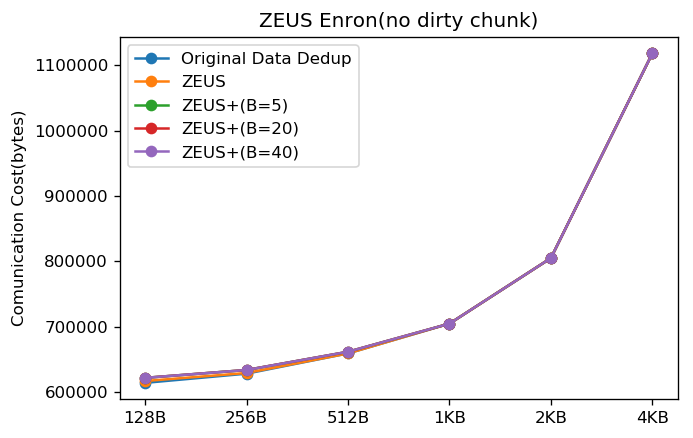

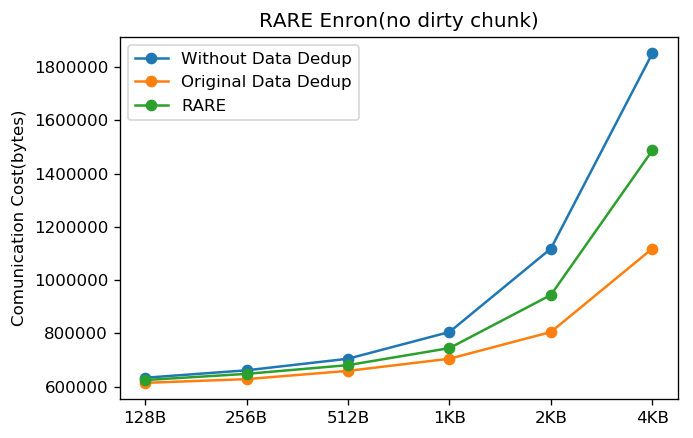

In [13]:
no_dirty = [origin_costs.copy(), zeus_costs.copy(), zeus5_costs.copy(), zeus20_costs.copy(), zeus40_costs.copy()]
no_dirty_rare = [no_dedup_costs.copy(), origin_dedup_costs.copy(), rare_costs.copy()]

print("Origin Data Dedup:", origin_costs)
print("ZEUS:             ", zeus_costs)
print("ZEUS+(B=5):       ", zeus5_costs)
print("ZEUS+(B=20):      ", zeus20_costs)
print("ZEUS+(B=40):      ", zeus40_costs)
print('-------------')
print("Without Data Dedup:", no_dedup_costs)
print("Rare:              ", rare_costs)
print("Origin Data Dedup: ", origin_dedup_costs)


%matplotlib inline
import matplotlib.pyplot as plt 
plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('ZEUS Enron(no dirty chunk)')
plt.show()

plt.figure(dpi = 120)
plt.plot(x, no_dedup_costs, '-o', label = 'Without Data Dedup')
plt.plot(x, origin_dedup_costs, '-o', label = 'Original Data Dedup')
plt.plot(x, rare_costs, '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('RARE Enron(no dirty chunk)')
plt.show()

In [14]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

origin_costs.clear()
zeus_costs.clear()
zeus5_costs.clear()
zeus20_costs.clear()
zeus40_costs.clear()

no_dedup_costs.clear()
origin_dedup_costs.clear()
rare_costs.clear()

# 10% dirty chunk 128B
upload_file(upload_files, 128)
cut_check_file(check_files, 128)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(128, False, True, 0))
zeus_costs.append(cal_commu_cost(128, True, True, 0))
zeus5_costs.append(cal_commu_cost(128, True, True, 5))
zeus20_costs.append(cal_commu_cost(128, True, True, 20))
zeus40_costs.append(cal_commu_cost(128, True, True, 40))

no_dedup_costs.append(rare_cost(128, False, False, False))
origin_dedup_costs.append(rare_cost(128, True, False, True))
rare_costs.append(rare_cost(128, True, True, True))

dirty original dedup with chunk size: 128 bytes, dedup times: 144, check times: 4946, dedup percentage: 2.911444 %
dirty ZEUS with chunk size: 128 bytes, dedup times: 123, check times: 4946, dedup percentage: 2.486858 %
dirty ZEUS having threshold 5, with chunk size: 128 bytes, dedup times: 90, check times: 4946, dedup percentage: 1.819652 %
dirty ZEUS having threshold 20, with chunk size: 128 bytes, dedup times: 92, check times: 4946, dedup percentage: 1.860089 %
dirty ZEUS having threshold 40, with chunk size: 128 bytes, dedup times: 92, check times: 4946, dedup percentage: 1.860089 %
no dedup with chunk size: 128 bytes, dedup times: 0, check times: 4946, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 128 bytes, dedup times: 144, check times: 4946, dedup percentage: 2.911444 %
dirty RARE with chunk size: 128 bytes, dedup times: 60, check times: 4946, dedup percentage: 1.213101 %


In [15]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 10% dirty chunk 256B
upload_file(upload_files, 256)
cut_check_file(check_files, 256)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(256, False, True, 0))
zeus_costs.append(cal_commu_cost(256, True, True, 0))
zeus5_costs.append(cal_commu_cost(256, True, True, 5))
zeus20_costs.append(cal_commu_cost(256, True, True, 20))
zeus40_costs.append(cal_commu_cost(256, True, True, 40))
no_dedup_costs.append(rare_cost(256, False, False, False))
origin_dedup_costs.append(rare_cost(256, True, False, True))
rare_costs.append(rare_cost(256, True, True, True))

dirty original dedup with chunk size: 256 bytes, dedup times: 126, check times: 2582, dedup percentage: 4.879938 %
dirty ZEUS with chunk size: 256 bytes, dedup times: 123, check times: 2582, dedup percentage: 4.763749 %
dirty ZEUS having threshold 5, with chunk size: 256 bytes, dedup times: 109, check times: 2582, dedup percentage: 4.221534 %
dirty ZEUS having threshold 20, with chunk size: 256 bytes, dedup times: 109, check times: 2582, dedup percentage: 4.221534 %
dirty ZEUS having threshold 40, with chunk size: 256 bytes, dedup times: 110, check times: 2582, dedup percentage: 4.260263 %
no dedup with chunk size: 256 bytes, dedup times: 0, check times: 2582, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 256 bytes, dedup times: 126, check times: 2582, dedup percentage: 4.879938 %
dirty RARE with chunk size: 256 bytes, dedup times: 59, check times: 2582, dedup percentage: 2.285050 %


In [16]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 10% dirty chunk 512B
upload_file(upload_files, 512)
cut_check_file(check_files, 512)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(512, False, True, 0))
zeus_costs.append(cal_commu_cost(512, True, True, 0))
zeus5_costs.append(cal_commu_cost(512, True, True, 5))
zeus20_costs.append(cal_commu_cost(512, True, True, 20))
zeus40_costs.append(cal_commu_cost(512, True, True, 40))
no_dedup_costs.append(rare_cost(512, False, False, False))
origin_dedup_costs.append(rare_cost(512, True, False, True))
rare_costs.append(rare_cost(512, True, True, True))

dirty original dedup with chunk size: 512 bytes, dedup times: 88, check times: 1376, dedup percentage: 6.395349 %
dirty ZEUS with chunk size: 512 bytes, dedup times: 88, check times: 1376, dedup percentage: 6.395349 %
dirty ZEUS having threshold 5, with chunk size: 512 bytes, dedup times: 85, check times: 1376, dedup percentage: 6.177326 %
dirty ZEUS having threshold 20, with chunk size: 512 bytes, dedup times: 85, check times: 1376, dedup percentage: 6.177326 %
dirty ZEUS having threshold 40, with chunk size: 512 bytes, dedup times: 85, check times: 1376, dedup percentage: 6.177326 %
no dedup with chunk size: 512 bytes, dedup times: 0, check times: 1376, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 512 bytes, dedup times: 88, check times: 1376, dedup percentage: 6.395349 %
dirty RARE with chunk size: 512 bytes, dedup times: 44, check times: 1376, dedup percentage: 3.197674 %


In [17]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 10% dirty chunk 1KB
upload_file(upload_files, 1024)
cut_check_file(check_files, 1024)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(1024, False, True, 0))
zeus_costs.append(cal_commu_cost(1024, True, True, 0))
zeus5_costs.append(cal_commu_cost(1024, True, True, 5))
zeus20_costs.append(cal_commu_cost(1024, True, True, 20))
zeus40_costs.append(cal_commu_cost(1024, True, True, 40))
no_dedup_costs.append(rare_cost(1024, False, False, False))
origin_dedup_costs.append(rare_cost(1024, True, False, True))
rare_costs.append(rare_cost(1024, True, True, True))

dirty original dedup with chunk size: 1024 bytes, dedup times: 98, check times: 786, dedup percentage: 12.468193 %
dirty ZEUS with chunk size: 1024 bytes, dedup times: 98, check times: 786, dedup percentage: 12.468193 %
dirty ZEUS having threshold 5, with chunk size: 1024 bytes, dedup times: 98, check times: 786, dedup percentage: 12.468193 %
dirty ZEUS having threshold 20, with chunk size: 1024 bytes, dedup times: 98, check times: 786, dedup percentage: 12.468193 %
dirty ZEUS having threshold 40, with chunk size: 1024 bytes, dedup times: 98, check times: 786, dedup percentage: 12.468193 %
no dedup with chunk size: 1024 bytes, dedup times: 0, check times: 786, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 1024 bytes, dedup times: 98, check times: 786, dedup percentage: 12.468193 %
dirty RARE with chunk size: 1024 bytes, dedup times: 52, check times: 786, dedup percentage: 6.615776 %


In [18]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 10% dirty chunk 2KB
upload_file(upload_files, 2048)
cut_check_file(check_files, 2048)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(2048, False, True, 0))
zeus_costs.append(cal_commu_cost(2048, True, True, 0))
zeus5_costs.append(cal_commu_cost(2048, True, True, 5))
zeus20_costs.append(cal_commu_cost(2048, True, True, 20))
zeus40_costs.append(cal_commu_cost(2048, True, True, 40))

no_dedup_costs.append(rare_cost(2048, False, False, False))
origin_dedup_costs.append(rare_cost(2048, True, False, True))
rare_costs.append(rare_cost(2048, True, True, True))

dirty original dedup with chunk size: 2048 bytes, dedup times: 153, check times: 546, dedup percentage: 28.021978 %
dirty ZEUS with chunk size: 2048 bytes, dedup times: 153, check times: 546, dedup percentage: 28.021978 %
dirty ZEUS having threshold 5, with chunk size: 2048 bytes, dedup times: 153, check times: 546, dedup percentage: 28.021978 %
dirty ZEUS having threshold 20, with chunk size: 2048 bytes, dedup times: 153, check times: 546, dedup percentage: 28.021978 %
dirty ZEUS having threshold 40, with chunk size: 2048 bytes, dedup times: 153, check times: 546, dedup percentage: 28.021978 %
no dedup with chunk size: 2048 bytes, dedup times: 0, check times: 546, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 2048 bytes, dedup times: 153, check times: 546, dedup percentage: 28.021978 %
dirty RARE with chunk size: 2048 bytes, dedup times: 64, check times: 546, dedup percentage: 11.721612 %


In [19]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 10% dirty chunk 4KB
upload_file(upload_files, 4096)
cut_check_file(check_files, 4096)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(4096, False, True, 0))
zeus_costs.append(cal_commu_cost(4096, True, True, 0))
zeus5_costs.append(cal_commu_cost(4096, True, True, 5))
zeus20_costs.append(cal_commu_cost(4096, True, True, 20))
zeus40_costs.append(cal_commu_cost(4096, True, True, 40))

no_dedup_costs.append(rare_cost(4096, False, False, False))
origin_dedup_costs.append(rare_cost(4096, True, False, True))
rare_costs.append(rare_cost(4096, True, True, True))

dirty original dedup with chunk size: 4096 bytes, dedup times: 179, check times: 452, dedup percentage: 39.601770 %
dirty ZEUS with chunk size: 4096 bytes, dedup times: 179, check times: 452, dedup percentage: 39.601770 %
dirty ZEUS having threshold 5, with chunk size: 4096 bytes, dedup times: 179, check times: 452, dedup percentage: 39.601770 %
dirty ZEUS having threshold 20, with chunk size: 4096 bytes, dedup times: 179, check times: 452, dedup percentage: 39.601770 %
dirty ZEUS having threshold 40, with chunk size: 4096 bytes, dedup times: 179, check times: 452, dedup percentage: 39.601770 %
no dedup with chunk size: 4096 bytes, dedup times: 0, check times: 452, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 4096 bytes, dedup times: 179, check times: 452, dedup percentage: 39.601770 %
dirty RARE with chunk size: 4096 bytes, dedup times: 93, check times: 452, dedup percentage: 20.575221 %


Origin Data Dedup: [614656, 628736, 659456, 704512, 804864, 1118208]
ZEUS:              [617344, 629504, 659456, 704512, 804864, 1118208]
ZEUS+(B=5):        [621568, 633088, 660992, 704512, 804864, 1118208]
ZEUS+(B=20):       [621312, 633088, 660992, 704512, 804864, 1118208]
ZEUS+(B=40):       [621312, 632832, 660992, 704512, 804864, 1118208]
-------------
Without Data Dedup: [633088, 660992, 704512, 804864, 1118208, 1851392]
Rare:               [625408, 645888, 681984, 751616, 987136, 1470464]
Origin Data Dedup:  [614656, 628736, 659456, 704512, 804864, 1118208]


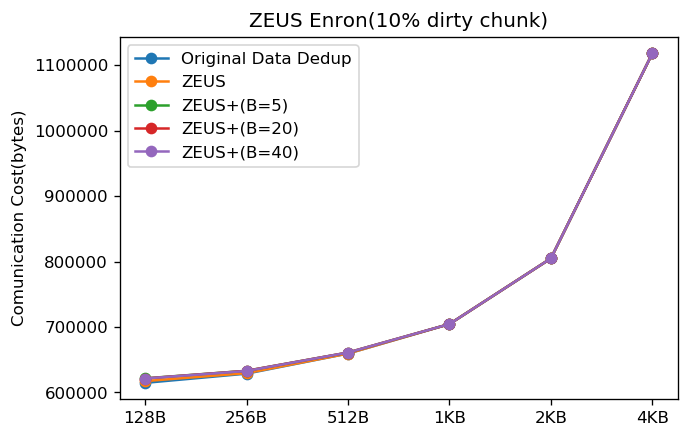

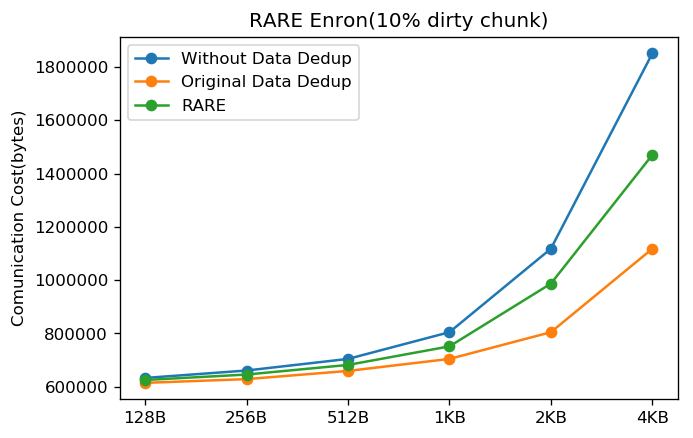

In [20]:
dirty10 = [origin_costs.copy(), zeus_costs.copy(), zeus5_costs.copy(), zeus20_costs.copy(), zeus40_costs.copy()]
dirty10_rare = [no_dedup_costs.copy(), origin_dedup_costs.copy(), rare_costs.copy()]

print("Origin Data Dedup:", origin_costs)
print("ZEUS:             ", zeus_costs)
print("ZEUS+(B=5):       ", zeus5_costs)
print("ZEUS+(B=20):      ", zeus20_costs)
print("ZEUS+(B=40):      ", zeus40_costs)
print('-------------')
print("Without Data Dedup:", no_dedup_costs)
print("Rare:              ", rare_costs)
print("Origin Data Dedup: ", origin_dedup_costs)

plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('ZEUS Enron(10% dirty chunk)')
plt.show()

plt.figure(dpi = 120)
plt.plot(x, no_dedup_costs, '-o', label = 'Without Data Dedup')
plt.plot(x, origin_dedup_costs, '-o', label = 'Original Data Dedup')
plt.plot(x, rare_costs, '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('RARE Enron(10% dirty chunk)')
plt.show()

In [21]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

origin_costs.clear()
zeus_costs.clear()
zeus5_costs.clear()
zeus20_costs.clear()
zeus40_costs.clear()

no_dedup_costs.clear()
origin_dedup_costs.clear()
rare_costs.clear()

# 25% dirty chunk 128B
upload_file(upload_files, 128)
cut_check_file(check_files, 128)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(128, False, True, 0))
zeus_costs.append(cal_commu_cost(128, True, True, 0))
zeus5_costs.append(cal_commu_cost(128, True, True, 5))
zeus20_costs.append(cal_commu_cost(128, True, True, 20))
zeus40_costs.append(cal_commu_cost(128, True, True, 40))
no_dedup_costs.append(rare_cost(128, False, False, False))
origin_dedup_costs.append(rare_cost(128, True, False, True))
rare_costs.append(rare_cost(128, True, True, True))

dirty original dedup with chunk size: 128 bytes, dedup times: 132, check times: 4946, dedup percentage: 2.668823 %
dirty ZEUS with chunk size: 128 bytes, dedup times: 113, check times: 4946, dedup percentage: 2.284674 %
dirty ZEUS having threshold 5, with chunk size: 128 bytes, dedup times: 92, check times: 4946, dedup percentage: 1.860089 %
dirty ZEUS having threshold 20, with chunk size: 128 bytes, dedup times: 90, check times: 4946, dedup percentage: 1.819652 %
dirty ZEUS having threshold 40, with chunk size: 128 bytes, dedup times: 90, check times: 4946, dedup percentage: 1.819652 %
no dedup with chunk size: 128 bytes, dedup times: 0, check times: 4946, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 128 bytes, dedup times: 132, check times: 4946, dedup percentage: 2.668823 %
dirty RARE with chunk size: 128 bytes, dedup times: 53, check times: 4946, dedup percentage: 1.071573 %


In [22]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 25% dirty chunk 256B
upload_file(upload_files, 256)
cut_check_file(check_files, 256)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(256, False, True, 0))
zeus_costs.append(cal_commu_cost(256, True, True, 0))
zeus5_costs.append(cal_commu_cost(256, True, True, 5))
zeus20_costs.append(cal_commu_cost(256, True, True, 20))
zeus40_costs.append(cal_commu_cost(256, True, True, 40))
no_dedup_costs.append(rare_cost(256, False, False, False))
origin_dedup_costs.append(rare_cost(256, True, False, True))
rare_costs.append(rare_cost(256, True, True, True))

dirty original dedup with chunk size: 256 bytes, dedup times: 122, check times: 2582, dedup percentage: 4.725019 %
dirty ZEUS with chunk size: 256 bytes, dedup times: 118, check times: 2582, dedup percentage: 4.570101 %
dirty ZEUS having threshold 5, with chunk size: 256 bytes, dedup times: 111, check times: 2582, dedup percentage: 4.298993 %
dirty ZEUS having threshold 20, with chunk size: 256 bytes, dedup times: 108, check times: 2582, dedup percentage: 4.182804 %
dirty ZEUS having threshold 40, with chunk size: 256 bytes, dedup times: 108, check times: 2582, dedup percentage: 4.182804 %
no dedup with chunk size: 256 bytes, dedup times: 0, check times: 2582, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 256 bytes, dedup times: 122, check times: 2582, dedup percentage: 4.725019 %
dirty RARE with chunk size: 256 bytes, dedup times: 54, check times: 2582, dedup percentage: 2.091402 %


In [23]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 25% dirty chunk 512B
upload_file(upload_files, 512)
cut_check_file(check_files, 512)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(512, False, True, 0))
zeus_costs.append(cal_commu_cost(512, True, True, 0))
zeus5_costs.append(cal_commu_cost(512, True, True, 5))
zeus20_costs.append(cal_commu_cost(512, True, True, 20))
zeus40_costs.append(cal_commu_cost(512, True, True, 40))
no_dedup_costs.append(rare_cost(512, False, False, False))
origin_dedup_costs.append(rare_cost(512, True, False, True))
rare_costs.append(rare_cost(512, True, True, True))

dirty original dedup with chunk size: 512 bytes, dedup times: 89, check times: 1376, dedup percentage: 6.468023 %
dirty ZEUS with chunk size: 512 bytes, dedup times: 89, check times: 1376, dedup percentage: 6.468023 %
dirty ZEUS having threshold 5, with chunk size: 512 bytes, dedup times: 85, check times: 1376, dedup percentage: 6.177326 %
dirty ZEUS having threshold 20, with chunk size: 512 bytes, dedup times: 85, check times: 1376, dedup percentage: 6.177326 %
dirty ZEUS having threshold 40, with chunk size: 512 bytes, dedup times: 85, check times: 1376, dedup percentage: 6.177326 %
no dedup with chunk size: 512 bytes, dedup times: 0, check times: 1376, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 512 bytes, dedup times: 89, check times: 1376, dedup percentage: 6.468023 %
dirty RARE with chunk size: 512 bytes, dedup times: 38, check times: 1376, dedup percentage: 2.761628 %


In [24]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 25% dirty chunk 1KB
upload_file(upload_files, 1024)
cut_check_file(check_files, 1024)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(1024, False, True, 0))
zeus_costs.append(cal_commu_cost(1024, True, True, 0))
zeus5_costs.append(cal_commu_cost(1024, True, True, 5))
zeus20_costs.append(cal_commu_cost(1024, True, True, 20))
zeus40_costs.append(cal_commu_cost(1024, True, True, 40))
no_dedup_costs.append(rare_cost(1024, False, False, False))
origin_dedup_costs.append(rare_cost(1024, True, False, True))
rare_costs.append(rare_cost(1024, True, True, True))

dirty original dedup with chunk size: 1024 bytes, dedup times: 98, check times: 786, dedup percentage: 12.468193 %
dirty ZEUS with chunk size: 1024 bytes, dedup times: 98, check times: 786, dedup percentage: 12.468193 %
dirty ZEUS having threshold 5, with chunk size: 1024 bytes, dedup times: 98, check times: 786, dedup percentage: 12.468193 %
dirty ZEUS having threshold 20, with chunk size: 1024 bytes, dedup times: 98, check times: 786, dedup percentage: 12.468193 %
dirty ZEUS having threshold 40, with chunk size: 1024 bytes, dedup times: 98, check times: 786, dedup percentage: 12.468193 %
no dedup with chunk size: 1024 bytes, dedup times: 0, check times: 786, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 1024 bytes, dedup times: 98, check times: 786, dedup percentage: 12.468193 %
dirty RARE with chunk size: 1024 bytes, dedup times: 50, check times: 786, dedup percentage: 6.361323 %


In [25]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 25% dirty chunk 2KB
upload_file(upload_files, 2048)
cut_check_file(check_files, 2048)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(2048, False, True, 0))
zeus_costs.append(cal_commu_cost(2048, True, True, 0))
zeus5_costs.append(cal_commu_cost(2048, True, True, 5))
zeus20_costs.append(cal_commu_cost(2048, True, True, 20))
zeus40_costs.append(cal_commu_cost(2048, True, True, 40))
no_dedup_costs.append(rare_cost(2048, False, False, False))
origin_dedup_costs.append(rare_cost(2048, True, False, True))
rare_costs.append(rare_cost(2048, True, True, True))

dirty original dedup with chunk size: 2048 bytes, dedup times: 153, check times: 546, dedup percentage: 28.021978 %
dirty ZEUS with chunk size: 2048 bytes, dedup times: 153, check times: 546, dedup percentage: 28.021978 %
dirty ZEUS having threshold 5, with chunk size: 2048 bytes, dedup times: 153, check times: 546, dedup percentage: 28.021978 %
dirty ZEUS having threshold 20, with chunk size: 2048 bytes, dedup times: 153, check times: 546, dedup percentage: 28.021978 %
dirty ZEUS having threshold 40, with chunk size: 2048 bytes, dedup times: 153, check times: 546, dedup percentage: 28.021978 %
no dedup with chunk size: 2048 bytes, dedup times: 0, check times: 546, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 2048 bytes, dedup times: 153, check times: 546, dedup percentage: 28.021978 %
dirty RARE with chunk size: 2048 bytes, dedup times: 66, check times: 546, dedup percentage: 12.087912 %


In [26]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 25% dirty chunk 4KB
upload_file(upload_files, 4096)
cut_check_file(check_files, 4096)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(4096, False, True, 0))
zeus_costs.append(cal_commu_cost(4096, True, True, 0))
zeus5_costs.append(cal_commu_cost(4096, True, True, 5))
zeus20_costs.append(cal_commu_cost(4096, True, True, 20))
zeus40_costs.append(cal_commu_cost(4096, True, True, 40))
no_dedup_costs.append(rare_cost(4096, False, False, False))
origin_dedup_costs.append(rare_cost(4096, True, False, True))
rare_costs.append(rare_cost(4096, True, True, True))

dirty original dedup with chunk size: 4096 bytes, dedup times: 179, check times: 452, dedup percentage: 39.601770 %
dirty ZEUS with chunk size: 4096 bytes, dedup times: 179, check times: 452, dedup percentage: 39.601770 %
dirty ZEUS having threshold 5, with chunk size: 4096 bytes, dedup times: 179, check times: 452, dedup percentage: 39.601770 %
dirty ZEUS having threshold 20, with chunk size: 4096 bytes, dedup times: 179, check times: 452, dedup percentage: 39.601770 %
dirty ZEUS having threshold 40, with chunk size: 4096 bytes, dedup times: 179, check times: 452, dedup percentage: 39.601770 %
no dedup with chunk size: 4096 bytes, dedup times: 0, check times: 452, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 4096 bytes, dedup times: 179, check times: 452, dedup percentage: 39.601770 %
dirty RARE with chunk size: 4096 bytes, dedup times: 91, check times: 452, dedup percentage: 20.132743 %


Origin Data Dedup: [616192, 629760, 658944, 704512, 804864, 1118208]
ZEUS:              [618624, 630784, 658944, 704512, 804864, 1118208]
ZEUS+(B=5):        [621312, 632576, 660992, 704512, 804864, 1118208]
ZEUS+(B=20):       [621568, 633344, 660992, 704512, 804864, 1118208]
ZEUS+(B=40):       [621568, 633344, 660992, 704512, 804864, 1118208]
-------------
Without Data Dedup: [633088, 660992, 704512, 804864, 1118208, 1851392]
Rare:               [626304, 647168, 685056, 753664, 983040, 1478656]
Origin Data Dedup:  [616192, 629760, 658944, 704512, 804864, 1118208]


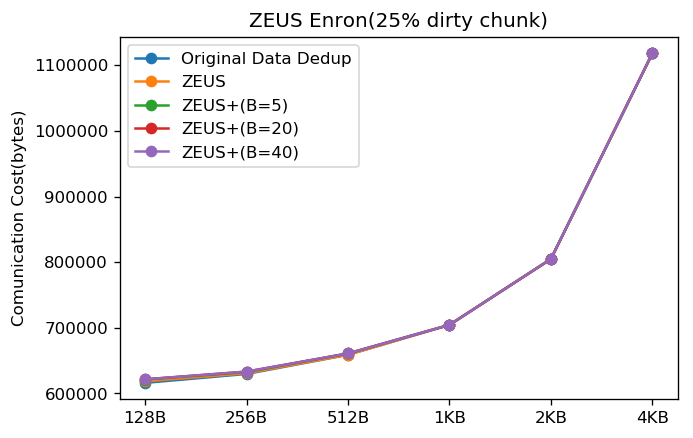

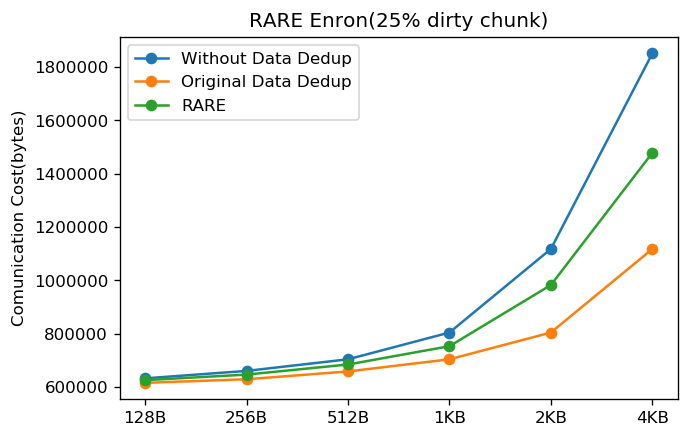

In [27]:
dirty25 = [origin_costs.copy(), zeus_costs.copy(), zeus5_costs.copy(), zeus20_costs.copy(), zeus40_costs.copy()]
dirty25_rare = [no_dedup_costs.copy(), origin_dedup_costs.copy(), rare_costs.copy()]

print("Origin Data Dedup:", origin_costs)
print("ZEUS:             ", zeus_costs)
print("ZEUS+(B=5):       ", zeus5_costs)
print("ZEUS+(B=20):      ", zeus20_costs)
print("ZEUS+(B=40):      ", zeus40_costs)
print('-------------')
print("Without Data Dedup:", no_dedup_costs)
print("Rare:              ", rare_costs)
print("Origin Data Dedup: ", origin_dedup_costs)

plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('ZEUS Enron(25% dirty chunk)')
plt.show()

plt.figure(dpi = 120)
plt.plot(x, no_dedup_costs, '-o', label = 'Without Data Dedup')
plt.plot(x, origin_dedup_costs, '-o', label = 'Original Data Dedup')
plt.plot(x, rare_costs, '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('RARE Enron(25% dirty chunk)')
plt.show()

no dirty chunk					 10% dirty chunk				 25% dirty chunk
ZEUS
['128B', '256B', '512B', '1KB', '2KB', '4KB']
[613888, 627968, 658944, 704512, 804864, 1118208] [614656, 628736, 659456, 704512, 804864, 1118208] [616192, 629760, 658944, 704512, 804864, 1118208]
[616704, 628992, 658944, 704512, 804864, 1118208] [617344, 629504, 659456, 704512, 804864, 1118208] [618624, 630784, 658944, 704512, 804864, 1118208]
[621568, 633600, 661504, 704512, 804864, 1118208] [621568, 633088, 660992, 704512, 804864, 1118208] [621312, 632576, 660992, 704512, 804864, 1118208]
[621568, 633600, 661504, 704512, 804864, 1118208] [621312, 633088, 660992, 704512, 804864, 1118208] [621568, 633344, 660992, 704512, 804864, 1118208]
[621568, 633600, 661504, 704512, 804864, 1118208] [621312, 632832, 660992, 704512, 804864, 1118208] [621568, 633344, 660992, 704512, 804864, 1118208]
--------------
RARE
[633088, 660992, 704512, 804864, 1118208, 1851392] [633088, 660992, 704512, 804864, 1118208, 1851392] [633088, 660992, 7045

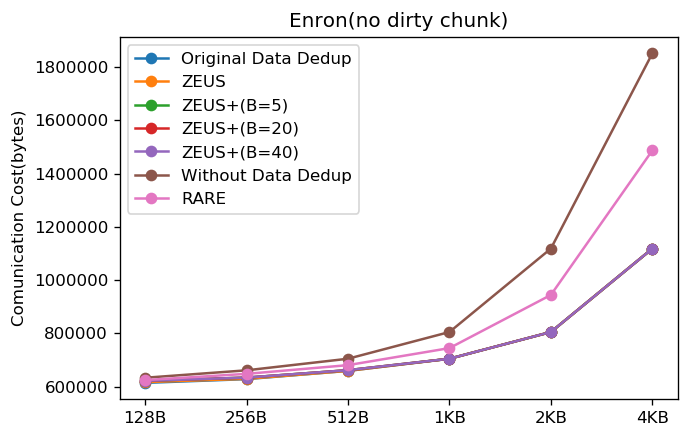

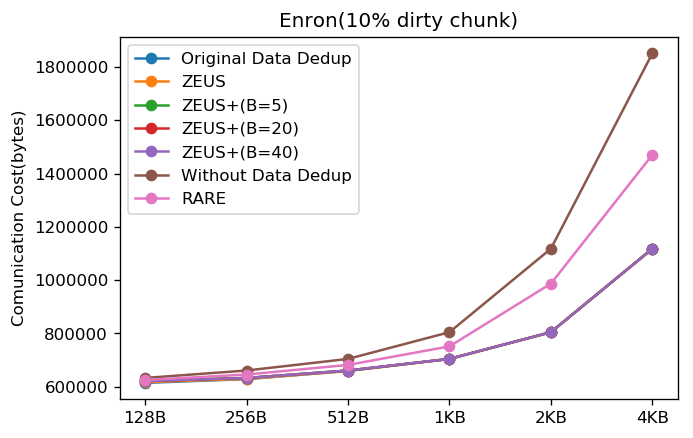

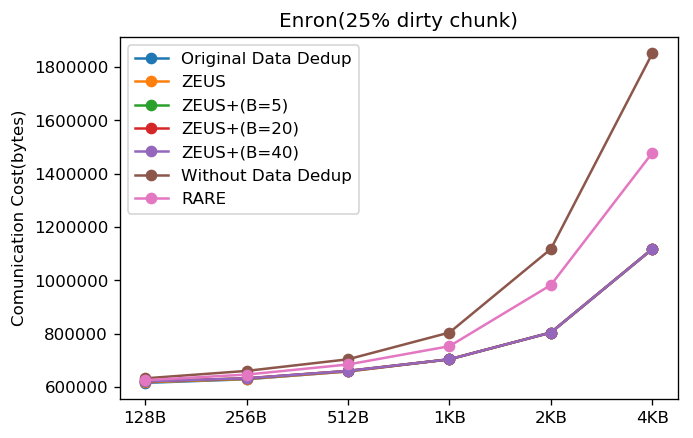

In [28]:
print('no dirty chunk\t\t\t\t\t', '10% dirty chunk\t\t\t\t', '25% dirty chunk')
print('ZEUS')
print(x)
for i in range(len(no_dirty)):
    print(no_dirty[i], dirty10[i], dirty25[i])
print('--------------')
print('RARE')
for i in range(len(no_dirty_rare)):
    print(no_dirty_rare[i], dirty10_rare[i], dirty25_rare[i])

plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, no_dirty[0],  '-o', label = 'Original Data Dedup')
plt.plot(x, no_dirty[1],  '-o', label = 'ZEUS')
plt.plot(x, no_dirty[2],  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, no_dirty[3],  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, no_dirty[4],  '-o', label = 'ZEUS+(B=40)')
plt.plot(x, no_dirty_rare[0], '-o', label = 'Without Data Dedup')
plt.plot(x, no_dirty_rare[2], '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('Enron(no dirty chunk)')
plt.show()
    
plt.figure(dpi = 120)
plt.plot(x, dirty10[0],  '-o', label = 'Original Data Dedup')
plt.plot(x, dirty10[1],  '-o', label = 'ZEUS')
plt.plot(x, dirty10[2],  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, dirty10[3],  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, dirty10[4],  '-o', label = 'ZEUS+(B=40)')
plt.plot(x, dirty10_rare[0], '-o', label = 'Without Data Dedup')
plt.plot(x, dirty10_rare[2], '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('Enron(10% dirty chunk)')
plt.show()

plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
plt.plot(x, dirty25_rare[0], '-o', label = 'Without Data Dedup')
plt.plot(x, dirty25_rare[2], '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('Enron(25% dirty chunk)')
plt.show()

# plt.subplot(131)
# plt.figure(dpi = 120)
# x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
# plt.plot(x, no_dirty[0],  '-o', label = 'Original Data Dedup')
# plt.plot(x, no_dirty[1],  '-o', label = 'ZEUS')
# plt.plot(x, no_dirty[2],  '-o', label = 'ZEUS+(B=5)')
# plt.plot(x, no_dirty[3],  '-o', label = 'ZEUS+(B=20)')
# plt.plot(x, no_dirty[4],  '-o', label = 'ZEUS+(B=40)')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('ZEUS Enron(no dirty chunk)')
# plt.show()

# plt.subplot(132)
# plt.figure(dpi = 120)
# plt.plot(x, dirty10[0],  '-o', label = 'Original Data Dedup')
# plt.plot(x, dirty10[1],  '-o', label = 'ZEUS')
# plt.plot(x, dirty10[2],  '-o', label = 'ZEUS+(B=5)')
# plt.plot(x, dirty10[3],  '-o', label = 'ZEUS+(B=20)')
# plt.plot(x, dirty10[4],  '-o', label = 'ZEUS+(B=40)')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('ZEUS Enron(10% dirty chunk)')
# plt.show()

# plt.subplot(133)
# plt.figure(dpi = 120)
# x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
# plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
# plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
# plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
# plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
# plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('ZEUS Enron(25% dirty chunk)')
# plt.show()

# plt.subplot(131)
# plt.figure(dpi = 120)
# plt.plot(x, no_dirty_rare[0], '-o', label = 'Without Data Dedup')
# plt.plot(x, no_dirty_rare[1], '-o', label = 'Original Data Dedup')
# plt.plot(x, no_dirty_rare[2], '-o', label = 'RARE')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('RARE Enron(no dirty chunk)')
# plt.show()

# plt.subplot(232)
# plt.figure(dpi = 120)
# plt.plot(x, dirty10_rare[0], '-o', label = 'Without Data Dedup')
# plt.plot(x, dirty10_rare[1], '-o', label = 'Original Data Dedup')
# plt.plot(x, dirty10_rare[2], '-o', label = 'RARE')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('RAER Enron(10% dirty chunk)')
# plt.show()

# plt.subplot(233)
# plt.figure(dpi = 120)
# plt.plot(x, dirty25_rare[0], '-o', label = 'Without Data Dedup')
# plt.plot(x, dirty25_rare[1], '-o', label = 'Original Data Dedup')
# plt.plot(x, dirty25_rare[2], '-o', label = 'RARE')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('RARE Enron(25% dirty chunk)')
# plt.show()